In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Flatten, BatchNormalization, Input ,concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
import glob
import os
import PIL
import time
!pip install emnist

from IPython import display

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/training_checkpoints_EMNIST'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

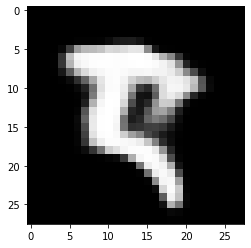

In [8]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [9]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
val = disc(sample)
print (val)

tf.Tensor([[-0.58260405]], shape=(1, 1), dtype=float32)


Now, we transfer the weights of discriminator to a new model, with the only difference being that the new model's last dense layer has 10 parameters instead of 1.

In [11]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(27, activation='softmax'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [12]:
# view the initialized weights and bias of the last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-1].weights

[<tf.Variable 'dense_2/kernel:0' shape=(6272, 27) dtype=float32, numpy=
 array([[-1.2141770e-02, -9.7135250e-03, -8.7887514e-03, ...,
          1.8467959e-03, -2.1037357e-02,  3.1080302e-03],
        [-2.7577877e-03,  2.6197080e-03, -1.7705405e-02, ...,
         -9.3108695e-03,  4.4567715e-03,  3.7612449e-03],
        [ 3.5968982e-04,  1.9082436e-02, -1.1374015e-02, ...,
          1.4791656e-03, -2.3774549e-02, -1.7160233e-03],
        ...,
        [-3.0732471e-02, -8.4059853e-03, -2.6864707e-03, ...,
          2.4628641e-02, -2.6607886e-05,  3.0041179e-02],
        [ 2.0654975e-02,  1.2301283e-02,  2.3957396e-02, ...,
          7.3208194e-03, -1.5763626e-02,  1.0253619e-03],
        [-8.5888803e-04,  2.8645596e-02,  1.6547533e-02, ...,
         -1.9649789e-02,  1.1881646e-03,  2.5625048e-02]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(27,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

In [13]:
from emnist import extract_training_samples, extract_test_samples
train_img, train_lb = extract_training_samples('letters')
test_img, test_lb = extract_test_samples('letters')

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 30000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(124800, 28, 28) (124800,) (20800, 28, 28) (20800,) 

(30000, 28, 28) (30000,) (10000, 28, 28) (10000,)


In [14]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

filepath = "/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_NET_"+"EMNIST"+"_best_weights.hdf5"
early_stop = EarlyStopping(monitor='val_accuracy', patience=50,mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stop]

history = new_model.fit(train_images, train_labels, batch_size=100, epochs=10,
                        validation_data=(test_images, test_labels),callbacks = callbacks_list)
# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = True 
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=10,
                        validation_data=(test_images, test_labels),callbacks = callbacks_list)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 2.5095 - accuracy: 0.4120
Epoch 1: val_accuracy improved from -inf to 0.56180, saving model to /content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_NET_EMNIST_best_weights.hdf5
300/300 [==============================] - 40s 132ms/step - loss: 2.5095 - accuracy: 0.4120 - val_loss: 1.9860 - val_accuracy: 0.5618
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 1.7764 - accuracy: 0.5803
Epoch 2: val_accuracy improved from 0.56180 to 0.61030, saving model to /content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_NET_EMNIST_best_weights.hdf5
300/300 [==============================] - 36s 119ms/step - loss: 1.7764 - accuracy: 0.5803 - val_loss: 1.5983 - val_accuracy: 0.6103
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 1.5104 - accuracy: 0.6200
Epoch 3: val_accuracy improved from 0.61030 to 0.63820, saving model to /content/drive/MyDrive/Colab Notebooks/SIFT+G

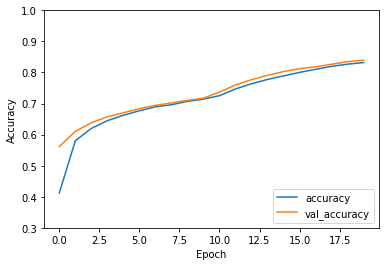

In [15]:
accuracy = history.history['accuracy'] + history1.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history1.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

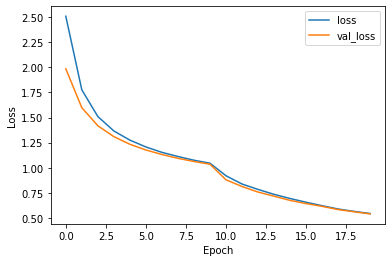

In [16]:
loss = history.history['loss'] + history1.history['loss']
val_loss = history.history['val_loss'] + history1.history['val_loss']

plt.figure()
plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.90 after 15 epochs.

1/1 [==============================] - 0s 39ms/step
[[2.5193349e-06 9.6339616e-05 6.8715820e-03 3.6582051e-07 3.8320042e-05
  2.8388291e-05 2.4249788e-05 2.0740301e-05 9.5975929e-01 2.3256039e-06
  1.6831476e-05 2.8809410e-02 1.2129901e-04 2.4343723e-05 7.9843332e-04
  3.5231784e-07 8.1829444e-07 3.9845686e-06 2.3450828e-04 5.4682436e-04
  4.5056899e-05 8.4128123e-06 6.3092906e-05 3.5715278e-05 2.0861288e-03
  3.2446891e-04 3.6234458e-05]]
prediction: 8


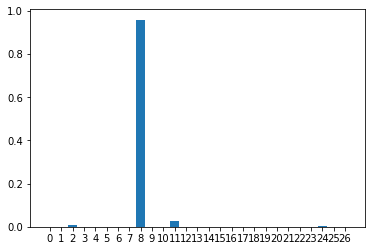

In [18]:
# demonstration: predict the ith test digit
i = 15
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,27).astype('str'), prediction[0,:])
plt.show()

actual label: 8


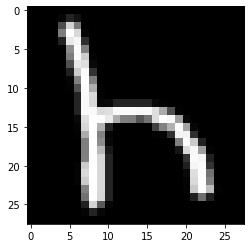

In [19]:
# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

In [20]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

313/313 [==============================] - 7s 23ms/step


In [21]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(true_labels, pred_labels)
confusion_mat

array([[306,   1,   0,  11,  10,   0,   5,  10,   0,   0,   4,   0,   1,
          4,   8,   5,  13,   1,   0,   0,   1,   0,   1,   3,   1,   1],
       [  5, 346,   0,   2,   2,   0,   6,   7,   1,   0,   1,   1,   0,
          1,   4,   0,   3,   2,   0,   0,   0,   0,   0,   1,   0,   6],
       [  6,   1, 357,   0,  13,   0,   2,   0,   1,   0,   2,   2,   0,
          0,   3,   0,   0,   3,   0,   0,   2,   0,   1,   0,   0,   1],
       [ 18,  15,   0, 281,   1,   1,   0,   4,   2,   1,   1,   1,   1,
          0,  32,   1,   3,   0,   1,   0,   1,   2,   0,   0,   0,   2],
       [  5,   2,  19,   0, 353,   6,   3,   0,   0,   0,   0,   0,   0,
          0,   1,   2,   0,   5,   0,   4,   0,   0,   0,   0,   0,   2],
       [  0,   1,   1,   1,   2, 321,   0,   1,   0,   1,   1,   4,   0,
          0,   0,  17,   3,   5,   5,  13,   0,   0,   0,   1,   2,   2],
       [ 12,  17,   9,   2,   9,   3, 236,   0,   0,   6,   1,   1,   1,
          0,   4,   3,  67,   1,  10,   1,   

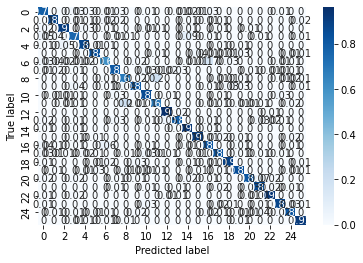

In [25]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,26).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
# plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()